# Aerosols scattering
==============================================================


- author : Sylvie Dagoret-Campagne
- date : May  18th 2017

In [11]:
import numpy as np
import pandas as pd

# Set up matplotlib and use a nicer set of plot parameters
#%config InlineBackend.rc = {}
import matplotlib
#matplotlib.rc_file("templates/matplotlibrc")
import matplotlib.pyplot as plt

%matplotlib inline

#import matplotlib as mpl

In [12]:
from astropy.constants import N_A,R,g0
from astropy import units as u

In [13]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

# Initialisation

## Constants

In [14]:
M_air= 28.965338*u.g/u.mol
M_air_dry=28.9644*u.g/u.mol
M_h2o=18.016*u.g/u.mol

In [15]:
P0=101325.*u.Pa;   # /*!< Pa : pressure at see level */
T0=288.15*u.K;   #/*!< sea level temperature */  
L=0.0065*u.K/u.m  # refroidissement en fonction de l'altitude

## Functions

### Attenuation at different altitudes

\begin{eqnarray}
\beta_a(h_2,\lambda) & = & \beta_a(h_1,\lambda) \exp\left( \frac{-(h_2-h_1)}{H_p}\right)  
\end{eqnarray}

$0.95 km < H_P < 1.5 km$

\begin{eqnarray}
\beta_a(h,\lambda) & = & \frac{\tau_{VAOD}}{H_p\cdot \left[ 1 - \exp \left( -\frac{h_2-h_1}{H_P}\right)\right]} \approx \frac{\tau_{VAOD}}{H_p}
\end{eqnarray}



\begin{eqnarray}
\tau_{HAOD}(h,\lambda) & = & \beta(h,\lambda)\cdot L = \frac{L}{H_P} \tau_{VAOD}
\end{eqnarray}

In [16]:
def Pressure_adiab(altitude):
    """
    Pressure( double altitude)
    Provide the pressure at the altitude.
    Attention, ici on considère de l'air sec.
    
    - Input : altitude : input altitude in meters
    - Output :pressure  : output pressure in Pa SI 
    """
    h=altitude
    P=P0*np.exp(-((g0*M_air_dry)/(R*T0))*h)
    return P  

### Pressure other definition

- $p_0 = $ sea level standard atmospheric pressure, 101.325 kPa
- $T_0 = $ sea level standard temperature, 288.15 K
- $g = $  earth-surface gravitational acceleration, 9.80665 m/s2
- $ L = $ temperature lapse rate, 0.0065 K/m (troposphere)
- $ R = $  ideal (universal) gas constant, 8.31447 J/(mol·K)
- $ M = $ molar mass of dry air, 0.0289644 kg/mol

Temperature at altitude $h$ meters above sea level is approximated by the following formula (only valid inside the troposphere):

$$
T = T_0 - L h 
$$

The pressure at altitude  $h$ is given by:
$$
   p = p_0 \left(1 - \frac{L h}{T_0} \right)^\frac{g M}{R L}
$$

Density can then be calculated according to a molar form of the ideal gas law:
$$
    \rho = \frac{p M}{R T}  
$$

where:

- $ M  = $ molar mass
- $ R  = $ ideal gas constant
- $ T  = $ absolute temperature
- $ p  = $ absolute pressure 

In [17]:
def Pressure(h):
    P=P0*np.exp(g0*M_air_dry/R/L*np.log(1-L*h/T0))
    return P

In [18]:
alt=np.linspace(0,20,100)*u.km
pres_adiab=Pressure_adiab(alt)
pres=Pressure(alt)

###  the atmospheric column depth $X$:
\begin{equation}
X(h,\theta)= P(h)/\cos \theta
\end{equation}


In [19]:
def XDepth(altitude,costh=1):
    """
    Function : XDepth(altitude,costh)
      Provide the column depth in gr / cm^2 equivalent of airmass in physical units
    - Input :  altitude : input altitude in meters
    - Input :  costh    : input cosimus of zenith angle 
    - Output :  XDepth  : output column depth in gr per cm squared
    """
    h=altitude
    XD=Pressure(h)/g0/costh
    return XD

## Aerosols models

La profondeur optique des aérosols $\tau_{AOD}$ peut être paramétrisée au plus simple par la formule:

$$
\tau_{AOD}  =  \tau_{aer}(\lambda_0) \left(\frac{\lambda_0}{\lambda}\right)^\alpha 
$$

In [30]:
def VAeroOptDepth(wavelength,tau_aerosols_550=0.10,alpha_ang=1.22) :
    """
    VAeroOptDepth(wavelength, alpha)

    Provide Vertical Aerosols optical depth
    - Input : wavelength : input wavelength in nm
    - Input : alpha : Angstrom exponent
    - Output : OptDepth  : output optical depth no unit for aerosols
    
    """

    OD=tau_aerosols_550*np.exp(-alpha_ang*np.log(wavelength/(550*u.nm)))
    return OD

In [31]:
wavelength=np.linspace(200.,1100.,100)*u.nm

In [36]:
VAOD=VAeroOptDepth(wavelength)

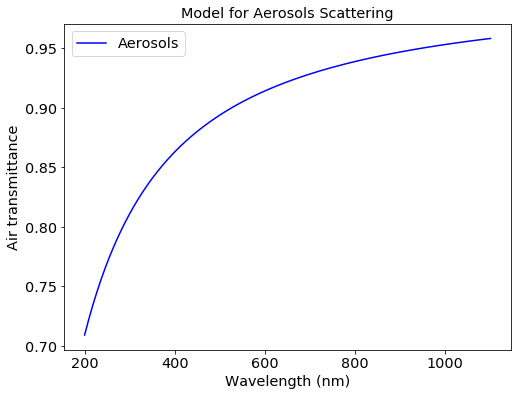

### VAOD
for quantiles 5% 10% 50% 90% 95%

In [35]:
VAOD_quantiles=np.array([0.03,0.0455,0.09,0.244,0.322]) # MERRA2

## Horizontal Aerosol Optical Depth

In [62]:
def HAeroOptDepth(wavelength,L,HP,tau_aerosols_550=0.10,alpha_ang=1.22) :
    """
    VAeroOptDepth(wavelength, alpha)

    Provide Vertical Aerosols optical depth
    - Input : wavelength : input wavelength in nm
    - Input : alpha : Angstrom exponent
    - Output : OptDepth  : output optical depth no unit for aerosols
    
    """
    
    
    VAOD=(L/HP)*VAeroOptDepth(wavelength,tau_aerosols_550,alpha_ang)
    
    
    return VAOD

In [59]:
HAOD=HAeroOptDepth(wavelength,L=200.*u.m)

In [61]:
(200*u.m/(1*u.km)).decompose()

<Quantity 0.2>

In [60]:
print HAOD

[ 68.70935665  65.08240495  61.78938005  58.78746621  56.04076669
  53.51897171  51.19632113  49.05078875  47.06343503  45.2178893
  43.49993211  41.89715622  40.3986892   38.99496534  37.67753672
  36.43891604  35.27244499  34.17218369  33.13281712  32.14957584
  31.21816836  30.33472324  29.49573939  28.69804326  27.93875171
  27.21523984  26.52511303  25.86618236  25.23644329  24.63405677
  24.05733266  23.50471512  22.97476965  22.46617159  21.9776959
  21.50820805  21.05665592  20.62206249  20.20351932  19.80018071
  19.41125843  19.03601693  18.6737691   18.32387235  17.98572511
  17.65876363  17.34245911  17.03631502  16.73986472  16.45266926
  16.17431538  15.90441368  15.64259693  15.38851852  15.14185107
  14.90228511  14.6695279   14.44330231  14.22334579  14.00940949
  13.80125731  13.59866515  13.40142017  13.20932007  13.02217245
  12.83979425  12.66201118  12.48865719  12.31957402  12.15461072
  11.99362328  11.83647419  11.68303214  11.53317161  11.38677262
  11.2437203

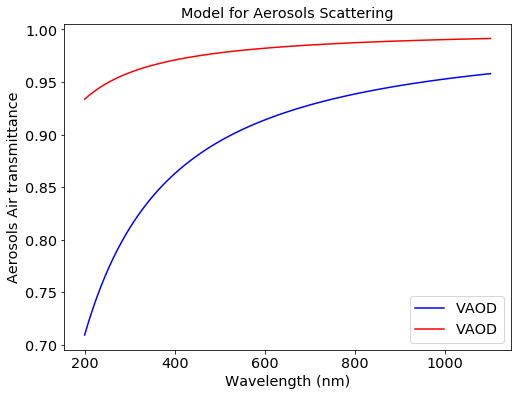

In [53]:
plt.plot(wavelength,np.exp(-VAOD),'b-',label='VAOD')
plt.plot(wavelength,np.exp(-HAOD.decompose()),'r-',label='VAOD')
plt.title('Model for Aerosols Scattering')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Aerosols Air transmittance')
plt.legend()